# Maze with risk

## Imports and environment settings

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import trange

In [2]:
# To reload the module
%load_ext autoreload
%autoreload 2

sys.path.append('../')
from src.network import Net, PolicyNet
from src.utils import fix_seeds
from maze.drl_methods import  online_categorical_TD_learning
from maze.maze_class import Qmaze, show, print_stoch_policy
from maze.mean_var import qtrain_mv, mean_var_training_actor_critic_fenchel_reg
from maze.cvar import qtrain_cvar

In [3]:
# Constantes
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = 4

In this notebook, when the agent reaches the special cells (in red : (4,3) and (0,3)), it receives a negative reward of $-perte$ with probability $p$.

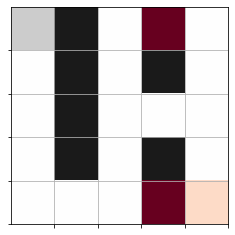

In [4]:
maze3 = np.array([[1.,0.,1.,-1.,1.],
                 [1.,0.,1.,0.,1.],
                 [1.,0.,1.,1.,1.],
                 [1.,0.,1.,0.,1.],
                 [1.,1.,1.,-1.,1.]])
perte = 0.37
p = 0.5

qmaze3 = Qmaze(maze=maze3, random_init=False, door_mode=False, perte=perte, prob_door_close=p)
show(qmaze3)

We begin by displaying the estimated distribution of the returns in this environment.

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

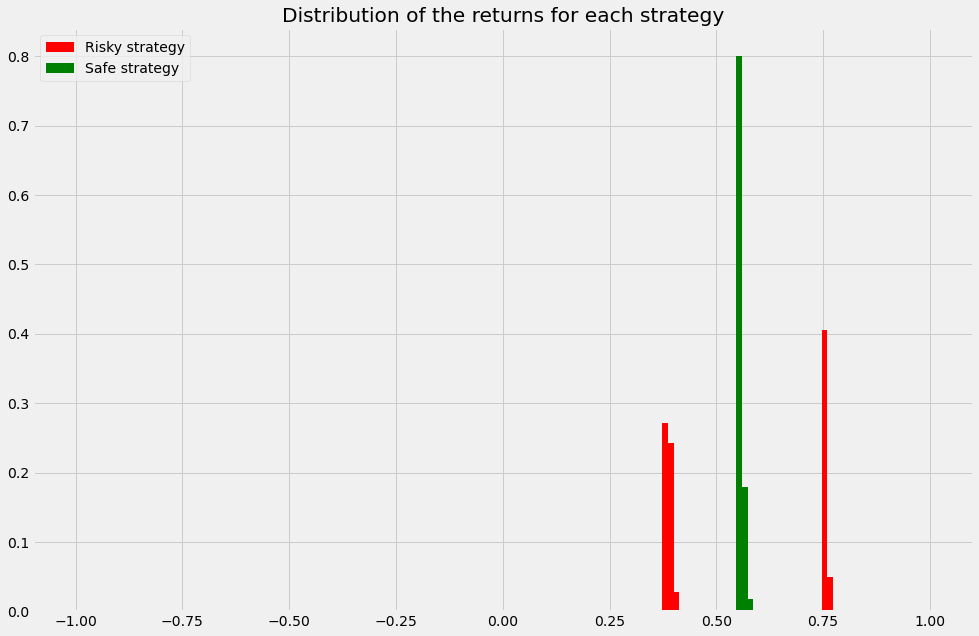

In [28]:
model3 = Net(maze3.size, num_actions)
model3.load('../parameters/model_parameters/model_parameters_config_3.pt')

model2 = Net(maze3.size, num_actions)
model2.load('../parameters/model_parameters/model_parameters_config_2.pt')
rat_cell = (0,0)

m=150
V_min = -1.
V_max = 1.

fix_seeds()

P_risky = online_categorical_TD_learning(model3, m, V_min, V_max, qmaze3, n_episode=500)
P_start_risky = P_risky[:,0,0]
P_safe = online_categorical_TD_learning(model2, m, V_min, V_max, qmaze3, n_episode=100)
P_start_safe = P_safe[:,0,0]

theta = np.linspace(V_min, V_max, m)
plt.figure(figsize=(15,10))
plt.hist(theta, weights=P_start_risky, bins=m, label='Risky strategy', color='r')
plt.hist(theta, weights=P_start_safe, bins=m, label="Safe strategy", color='g')

plt.legend(loc='upper left')
plt.title("Distribution of the returns for each strategy")
plt.show()

## Mean-Variance



The goal of this section is to optmize the mean-variance risk measure which is defined , for a random variable $X$, as : $\rho_{MV,\lambda} = \mathbb{E}[X] - \lambda \mathbb{V}[X]$.

For the safe strategy : $ \rho_{MV,\lambda} = 0.56 $ 

For the risky strategy : $ \rho_{MV,\lambda} = 0.76 - perte \times p - \lambda ( perte^2 \times p(1-p) ) $

The following figure shows that increasing the penalization factor $\lambda$ makes the safe strategy optimal.

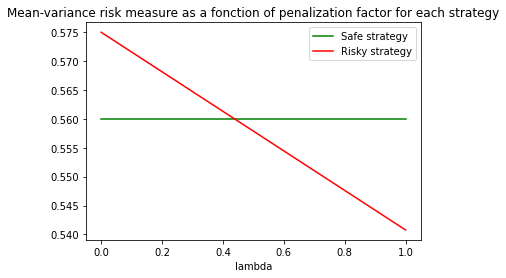

In [21]:
n_lambd = 5
tab_lambd = np.linspace(0,1,n_lambd)
plt.plot(tab_lambd, 0.56*np.ones(np.size(tab_lambd)), label='Safe strategy', color='g')
plt.plot(tab_lambd, 0.76-perte*p-tab_lambd*perte**2*p*(1-p), label='Risky strategy', color='r')
plt.legend()
plt.xlabel("lambda")
plt.title("Mean-variance risk measure as a fonction of penalization factor for each strategy")
plt.show()

### Distributional Q-learning for mean-variance optimization

#### Low penalization : risky strategy optimal

Epoch: 000/10000 | Risk Measure: -0.0039 | time: 0.0 seconds
Epoch: 001/10000 | Risk Measure: -0.0052 | time: 0.0 seconds
Epoch: 002/10000 | Risk Measure: -0.0039 | time: 0.1 seconds
Epoch: 003/10000 | Risk Measure: -0.0039 | time: 0.1 seconds
Epoch: 004/10000 | Risk Measure: -0.0039 | time: 0.1 seconds
Epoch: 005/10000 | Risk Measure: -0.0039 | time: 0.1 seconds
Epoch: 006/10000 | Risk Measure: -0.2926 | time: 0.2 seconds
Epoch: 007/10000 | Risk Measure: -0.2926 | time: 0.2 seconds
Epoch: 008/10000 | Risk Measure: -0.2926 | time: 0.2 seconds
Epoch: 009/10000 | Risk Measure: -0.2926 | time: 0.2 seconds
Epoch: 010/10000 | Risk Measure: -0.2926 | time: 0.2 seconds
Epoch: 011/10000 | Risk Measure: -0.4475 | time: 0.2 seconds
Epoch: 012/10000 | Risk Measure: -0.4475 | time: 0.2 seconds
Epoch: 013/10000 | Risk Measure: -0.4475 | time: 0.2 seconds
Epoch: 014/10000 | Risk Measure: -0.4475 | time: 0.3 seconds
Epoch: 015/10000 | Risk Measure: -0.4475 | time: 0.3 seconds
Epoch: 016/10000 | Risk 

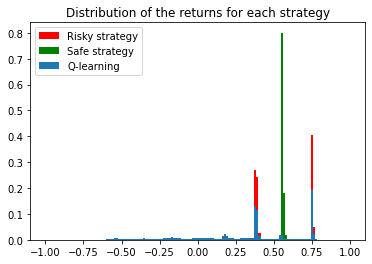

In [75]:
fix_seeds()
m = 150
V_min = -1.
V_max = 1.
nb_epochs = 10000
pen = 0.1
risk_measure_qtrain, P_qtrain = qtrain_mv(m, V_min, V_max, qmaze3, nb_epochs, pen, alpha=0.5, eps_decay=0.9)

theta = np.linspace(V_min, V_max, m)
P_start_qtrain = P_qtrain[:,0,0,3]

plt.hist(np.linspace(V_min, V_max, m), weights=P_start_risky, bins=m, label='Risky strategy', color='r')
plt.hist(np.linspace(V_min, V_max, m), weights=P_start_safe, bins=m, label="Safe strategy", color='g')
plt.hist(np.linspace(V_min, V_max, m), weights=P_start_qtrain, bins=m, label='Q-learning')

plt.legend(loc='upper left')
plt.title("Distribution of the returns for each strategy")
plt.show()

Finally, we run an episode to check the final policy is the risky one.

In [76]:
theta = np.linspace(V_min, V_max, m)

qmaze3.reset((0,0))
game_over = False
while not game_over:
    prev_row, prev_col,_ = qmaze3.state
    action = np.argmax([np.sum(P_qtrain[:, prev_row, prev_col,a]*theta) -
                        pen*(np.sum(P_qtrain[:, prev_row, prev_col,a]*theta**2)-np.sum(P_qtrain[:, prev_row, prev_col,a]*theta)**2) for a in range(num_actions)])
    print(actions_dict[action])
    _, reward, status = qmaze3.act(action)

    if status == 'win' or status == 'lose':
                            game_over = True

down
down
down
down
right
right
right
right


#### Strong penalization : safe strategy optimal

Epoch: 000/10000 | Risk Measure: -0.2933 | time: 0.0 seconds
Epoch: 001/10000 | Risk Measure: -0.2933 | time: 0.0 seconds
Epoch: 002/10000 | Risk Measure: -0.3425 | time: 0.0 seconds
Epoch: 003/10000 | Risk Measure: -0.3425 | time: 0.1 seconds
Epoch: 004/10000 | Risk Measure: -0.3425 | time: 0.1 seconds
Epoch: 005/10000 | Risk Measure: -0.3425 | time: 0.1 seconds
Epoch: 006/10000 | Risk Measure: -0.3425 | time: 0.1 seconds
Epoch: 007/10000 | Risk Measure: -0.3425 | time: 0.1 seconds
Epoch: 008/10000 | Risk Measure: -0.3425 | time: 0.2 seconds
Epoch: 009/10000 | Risk Measure: -0.3425 | time: 0.2 seconds
Epoch: 010/10000 | Risk Measure: -0.5511 | time: 0.2 seconds
Epoch: 011/10000 | Risk Measure: -0.6017 | time: 0.2 seconds
Epoch: 012/10000 | Risk Measure: -0.6017 | time: 0.3 seconds
Epoch: 013/10000 | Risk Measure: -0.6411 | time: 0.3 seconds
Epoch: 014/10000 | Risk Measure: -0.6411 | time: 0.3 seconds
Epoch: 015/10000 | Risk Measure: -0.6411 | time: 0.3 seconds
Epoch: 016/10000 | Risk 

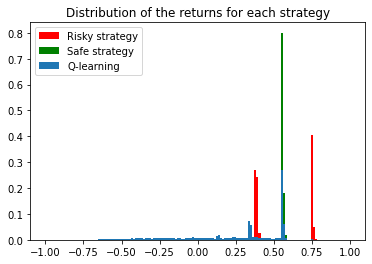

In [77]:
fix_seeds()
m = 150
V_min = -1.
V_max = 1.
nb_epochs = 10000
pen = 1.
risk_measure_qtrain, P_qtrain = qtrain_mv(m, V_min, V_max, qmaze3, nb_epochs, pen, alpha=0.5, eps_decay=0.9)

theta = np.linspace(V_min, V_max, m)
P_start_qtrain = P_qtrain[:,0,0,3]

plt.hist(np.linspace(V_min, V_max, m), weights=P_start_risky, bins=m, label='Risky strategy', color='r')
plt.hist(np.linspace(V_min, V_max, m), weights=P_start_safe, bins=m, label="Safe strategy", color='g')
plt.hist(np.linspace(V_min, V_max, m), weights=P_start_qtrain, bins=m, label='Q-learning')

plt.legend(loc='upper left')
plt.title("Distribution of the returns for each strategy")
plt.show()

Finally, we run an episode to check the final policy is the safe one.

In [78]:
qmaze3.reset((0,0))
game_over = False
while not game_over:
    prev_row, prev_col,_ = qmaze3.state
    action = np.argmax([np.sum(P_qtrain[:, prev_row, prev_col,a]*theta) -
                        pen*(np.sum(P_qtrain[:, prev_row, prev_col,a]*theta**2)-np.sum(P_qtrain[:, prev_row, prev_col,a]*theta)**2) for a in range(num_actions)])
    print(actions_dict[action])
    _, reward, status = qmaze3.act(action)

    if status == 'win' or status == 'lose':
        game_over = True

down
down
down
down
right
right
up
up
right
right
down
down


### Policy gradient methods

This section deals with *policy gradient methods* i.e. optimization of stochastic policies through gradient descent. 

The implemented method is actor-critic, which allow to learn online, and uses Legendre-Fenchel duality (see reference [2]) and entropic regularization.

#### Low penalization : risky strategy optimal

Epoch: 001/4000 | Risk Measure: 0.0000 | time: 0.1 seconds
Epoch: 002/4000 | Risk Measure: -4.0258 | time: 0.2 seconds
Epoch: 003/4000 | Risk Measure: -4.0258 | time: 0.3 seconds
Epoch: 004/4000 | Risk Measure: -4.0258 | time: 0.4 seconds
Epoch: 005/4000 | Risk Measure: -4.0258 | time: 0.6 seconds
Epoch: 006/4000 | Risk Measure: -4.4475 | time: 0.7 seconds
Epoch: 007/4000 | Risk Measure: -4.4475 | time: 0.8 seconds
Epoch: 008/4000 | Risk Measure: -4.6946 | time: 1.0 seconds
Epoch: 009/4000 | Risk Measure: -4.8324 | time: 1.1 seconds
Epoch: 010/4000 | Risk Measure: -4.8324 | time: 1.2 seconds
Epoch: 011/4000 | Risk Measure: -5.0328 | time: 1.4 seconds
Epoch: 012/4000 | Risk Measure: -5.9306 | time: 1.6 seconds
Epoch: 013/4000 | Risk Measure: -5.9306 | time: 1.7 seconds
Epoch: 014/4000 | Risk Measure: -5.9306 | time: 1.7 seconds
Epoch: 015/4000 | Risk Measure: -5.9306 | time: 1.8 seconds
Epoch: 016/4000 | Risk Measure: -6.4561 | time: 2.0 seconds
Epoch: 017/4000 | Risk Measure: -6.6929 |

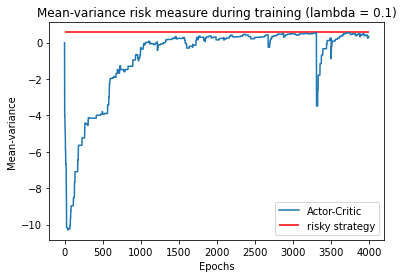

[['↓', '#', '↓', '→', '↓'],
 ['↓', '#', '↓', '#', '↓'],
 ['↓', '#', '↓', '→', '↓'],
 ['↓', '#', '↓', '#', '↓'],
 ['→', '→', '→', '→', 'G']]

In [94]:
nb_epochs = 4000
pen = 0.1
fix_seeds()
policy_model = PolicyNet(maze3.size, num_actions)

returns_ac= mean_var_training_actor_critic_fenchel_reg(policy_model, qmaze3, n_epoch=nb_epochs, 
                                                        lambd=pen, lr=0.001, alpha=0.3, gamma=1., tau=1.)
convol_param = 1
plt.plot(np.convolve(returns_ac, np.ones(convol_param)/convol_param, mode='valid'), label='Actor-Critic')
plt.hlines( 0.76-perte*p-pen*perte**2*p*(1-p), 0, nb_epochs, label='risky strategy', colors='r')
plt.legend()
plt.title("Mean-variance risk measure during training (lambda = "+str(pen)+")")
plt.xlabel("Epochs")
plt.ylabel("Mean-variance")
plt.show()

print_stoch_policy(policy_model,qmaze3) # to check the training went well

#### Strong penalization : safe strategy optimal

## CVaR Distributional Q-learning

This section concerns the CVaR optimization algorithm presented by Bellemare et al. [1] which is based on distributional Q-learning and state augmentation. For a random variable $Z$, we recall that $CVaR_{\tau}(Z) = \mathbb{E}[Z|Z\leq F_Z^{-1}(\tau)]$

First, we plot the distribution of the returns for each strategy and some quantiles of the risky strategy

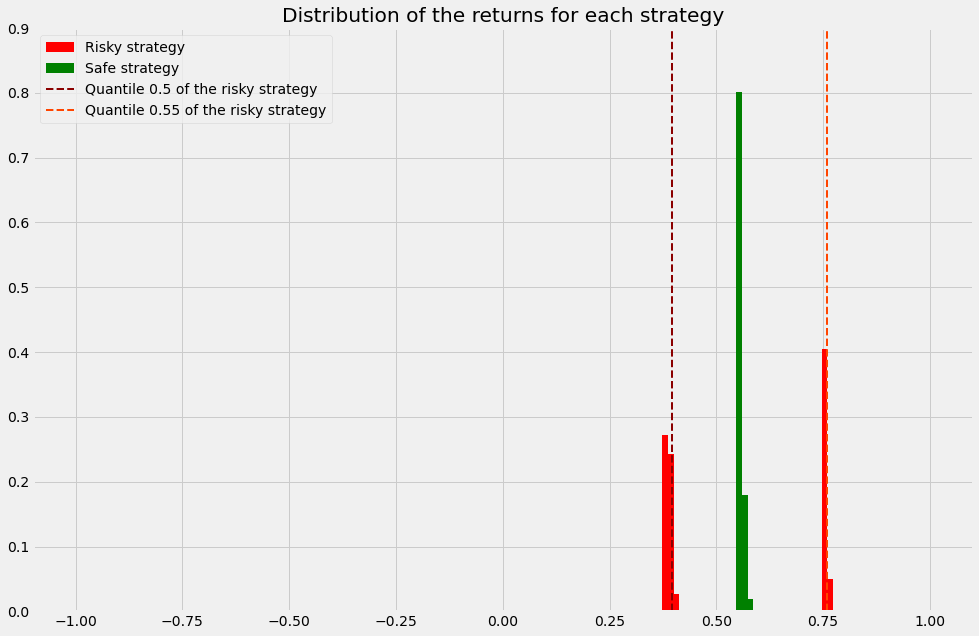

In [36]:
tau_1 = 0.5
q_tau_risky_1 = theta[np.where(np.cumsum(P_start_risky)>=tau_1)[0][0]]

tau_2 = 0.55
q_tau_risky_2 = theta[np.where(np.cumsum(P_start_risky)>=tau_2)[0][0]]

plt.figure(figsize=(15,10))
plt.hist(theta, weights=P_start_risky, bins=m, label='Risky strategy', color='r')
plt.hist(theta, weights=P_start_safe, bins=m, label="Safe strategy", color='g')
plt.vlines(q_tau_risky_1,0,0.9,linestyle="--",linewidth=2.,label="Quantile "+str(tau_1)+" of the risky strategy", color="darkred")
plt.vlines(q_tau_risky_2,0,0.9,linestyle="--",linewidth=2.,label="Quantile "+str(tau_2)+" of the risky strategy", color="orangered")
plt.ylim(0.,0.9)
plt.legend(loc='upper left')
plt.title("Distribution of the returns for each strategy")
plt.show()

In [5]:
def is_risky(P,qmaze,V_min,V_max,m,num_action=4):
    """
    Returns which strategy is derived from P
    """
    qmaze.reset((0,0))
    game_over = False
    theta = np.linspace(V_min, V_max, m)
    tab_B = np.linspace(qmaze.min_reward,1,m)
    prev_row,prev_col = (0,0)
    actions_init = [np.argmin([np.sum( (tab_B[i_b]-theta)*(tab_B[i_b]-theta >0)*P[:,prev_row,prev_col,i_b,a])
    for a in range(num_actions)]) for i_b in range(m)]
    idx_b = np.argmax([ b -np.sum((b-theta)*(b-theta >0)*P[:,prev_row,prev_col,i_b,actions_init[i_b]])/tau_ for i_b,b in enumerate(tab_B)])
    while not game_over:
        prev_row,prev_col,_ = qmaze.state
        action = np.argmin([ np.sum( (tab_B[idx_b]-theta)*(tab_B[idx_b]-theta >0)*P[:,prev_row,prev_col,idx_b,a] ) for a in range(num_action)])
        _, reward, status = qmaze.act(action)
        idx_b = np.argmin(np.abs(tab_B - (tab_B[idx_b]-reward)))
        if prev_row == 4 and prev_col== 2:
            return action
        if status == 'win' or status == 'lose':
            return -1

Then, we test the method for $\tau \in \{0.1,0.325,0.55,0.775,1.\} $. As expected, the risky strategy is optimal for the highest values of $\tau$ and the safe one for the smallest.

In [ ]:
fix_seeds()
m = 150
V_min = -1.
V_max = 1.
nb_epochs = 5000
tab_tau = np.linspace(0.1,1,5)
action_critic = []
for i in trange(np.size(tab_tau)):
    tau_ = tab_tau[i]
    P_cvar, tab_risk_measure = qtrain_cvar(m, V_min, V_max, qmaze3, n_epochs=nb_epochs, tau=tau_, gamma=1., 
                alpha=0.3, eps_decay=0.95)
    action_critic.append(is_risky(P_cvar,qmaze3,V_min,V_max,m))

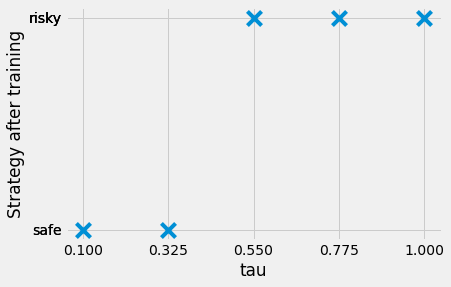

In [26]:
plt.style.use('fivethirtyeight')
plt.scatter(tab_tau,action_critic,s=200,marker="x")
plt.xticks(tab_tau)
labels = [["safe","risky"][i-1] for i in action_critic]
plt.yticks(action_critic,labels=labels)
plt.xlabel("tau")
plt.ylabel("Strategy after training")
plt.show()